In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import string
from math import log
from collections import Counter
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_log_error
import re
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import brown, words
from nltk.tag import UnigramTagger
import pymorphy2
import xgboost as xgb
import pickle

### Загружаем данные

In [18]:
df = pd.read_csv('./data/train.csv', dtype={'Password':str, 'Times':np.int32}, keep_default_na=False)

In [19]:
train_count = len(df)

In [20]:
dftest = pd.read_csv('./data/Xtest.csv', dtype={'Password':str, 'Times':np.int32}, keep_default_na=False)

In [48]:
set(dftest['Password']).intersection(known_pass)

{'cristiano',
 'baby21',
 'kokoro',
 '021191',
 '080188',
 '20052006',
 '140787',
 'mystikal',
 'juliane',
 'matter',
 'david4',
 'zahra',
 'baxter1',
 '121980',
 '300190',
 'LUCKY',
 'coolbaby',
 'summer21',
 'henkie',
 '100884',
 'DOMINIC',
 '2bornot2b',
 'paperclip',
 '050584',
 'alex99',
 'PEOPLE',
 'maybaby',
 'catita',
 'celeron',
 'unknown',
 'intermilan',
 'bonito',
 '221289',
 '050595',
 'happy23',
 'Anthony1',
 'lesbian1',
 'pasadena',
 'thomas7',
 'buford',
 '040692',
 'shang',
 'pink69',
 'lewis1',
 'ilovegary',
 'twenty2',
 'john16',
 'weller',
 'paul22',
 'password*',
 'noriega',
 'stiven',
 'black666',
 'stevie',
 'willie',
 'english',
 'maximiliano',
 'cherry69',
 'jessica23',
 'gotrice',
 'fernando1',
 '160388',
 '070107',
 'filiberto',
 'carley',
 's123456',
 'marial',
 'kakita',
 'dulce1',
 'llamas',
 'mamans',
 '181285',
 'ritchie',
 'loudmouth',
 '230986',
 'stewart1',
 'jesenia',
 'crimson1',
 'dashboard',
 '052389',
 'mariafe',
 '132132',
 'jordan14',
 'bloom',
 

#### Проверяем, что 1 пароль не встречается в тесте и трейне

In [21]:
set(dftest['Password']).intersection(set(df['Password']))

set()

#### Смотрим на самые популярные пароли

In [22]:
df.sort_values(['Times'], ascending=False).head(20)

,Password,Times
2715397,123456,55893
3136279,qwerty,13137
1175081,123456789,11696
2363307,12345,10938
2988373,1234,6432
2307329,111111,5682
3348280,1234567,4796
1795496,dragon,3927
3336606,123123,3845
3798071,baseball,3565


#### Проверяем отсутствие пустых значений

In [23]:
df['Password'][df['Password'].isnull()]

Series([], Name: Password, dtype: object)

In [24]:
df['Times'][df['Times'].isnull()]

Series([], Name: Times, dtype: int32)

In [25]:
df["Password"].describe()

count      4151496
unique     4151496
top       yakyuu55
freq             1
Name: Password, dtype: object

#### Логарифмируем таргет

In [26]:
df['Times'] = df['Times'].apply(lambda x: np.log1p(x))

### Генерируем признаки

In [ ]:
punctuation = set(string.punctuation)

In [ ]:
all_words = set(words.words())

In [ ]:
names = pd.read_csv('./data/names.csv', encoding='UTF-16')

In [ ]:
female_names = set(names['Girls'].apply(lambda x: x.lower()))
male_names = set(names['Boys'].apply(lambda x: x.lower()))

In [ ]:
morphs = pymorphy2.MorphAnalyzer()
tags = UnigramTagger(brown.tagged_sents(categories='news'))

#### Подключаем словари с паролями

In [ ]:
most10k = set()
with open('./data/10k-most-common.txt') as f:
    for line in f:
        most10k.add(line.strip())

In [ ]:
top100 = set()
with open('./data/10-million-password-list-top-100.txt') as f:
    for line in f:
        top100.add(line.strip())

In [ ]:
top500 = set()
with open('./data/10-million-password-list-top-500.txt') as f:
    for line in f:
        top500.add(line.strip())

In [ ]:
top1000 = set()
with open('./data/10-million-password-list-top-1000.txt') as f:
    for line in f:
        top1000.add(line.strip())

In [ ]:
top10000 = set()
with open('./data/10-million-password-list-top-10000.txt') as f:
    for line in f:
        top10000.add(line.strip())

In [ ]:
top100000 = set()
with open('./data/10-million-password-list-top-100000.txt') as f:
    for line in f:
        top100000.add(line.strip())

In [ ]:
top1000000 = set()
with open('./data/10-million-password-list-top-1000000.txt') as f:
    for line in f:
        top1000000.add(line.strip())

In [ ]:
worst500 = set()
with open('./data/500-worst-passwords.txt') as f:
    for line in f:
        worst500.add(line.strip())

In [ ]:
common_pass_win = set()
with open('./data/common-passwords-win.txt') as f:
    for line in f:
        common_pass_win.add(line.strip())

In [ ]:
def count_doubles(x):
    try:
        doubles = 0
        for i in range(len(x)-1):
            if x[i] == x[i+1]:
                doubles += 1
        return doubles/len(x)
    except:
        return 0

In [ ]:
def max_repeats(x):
    try: 
        return Counter(list(x)).most_common()[0][1]/len(x)
    except: 
        return 0

In [ ]:
close_keys = {
    '1': ['1', '2', 'q'],
    '2': ['1', '2', '3', 'q', 'w', 'e'],
    '3': ['4', '2', '3', 'r', 'w', 'e'],
    '4': ['4', '5', '3', 'r', 't', 'e'],
    '5': ['4', '5', '6', 'r', 't', 'y'],
    '6': ['7', '5', '6', 'u', 't', 'y'],
    '7': ['7', '8', '6', 'u', 'i', 'y'],
    '8': ['7', '8', '9', 'u', 'i', 'o'],
    '9': ['0', '8', '9', 'p', 'i', 'o'],
    '0': ['0', '9', 'p', 'o'],
    
    'q': ['1', '2', 'q', 'w', 'a', 's'],
    'w': ['1', '2', '3', 'q', 'w', 'e', 'a', 's', 'd'],
    'e': ['2', '3', '4', 'w', 'e', 'r', 's', 'd', 'f'],
    'r': ['3', '4', '5', 'e', 'r', 't', 'd', 'f', 'g'],
    't': ['4', '5', '6', 'r', 't', 'y', 'f', 'g', 'h'],
    'y': ['5', '6', '7', 't', 'y', 'u', 'g', 'h', 'j'],
    'u': ['6', '7', '8', 'y', 'u', 'i', 'h', 'j', 'k'],
    'i': ['7', '8', '9', 'u', 'i', 'o', 'j', 'k', 'l'],
    'o': ['8', '9', '0', 'i', 'o', 'p', 'k', 'l'],
    'p': ['9', '0', 'o', 'p', 'l'],
    
    'a': ['q', 'w', 'a', 's', 'z', 'x'],
    's': ['q', 'w', 'e', 'a', 's', 'd', 'z', 'x', 'c'],
    'd': ['w', 'e', 'r', 's', 'd', 'f', 'x', 'c', 'v'],
    'f': ['e', 'r', 't', 'd', 'f', 'g', 'c', 'v', 'b'],
    'g': ['r', 't', 'y', 'f', 'g', 'h', 'v', 'b', 'n'],
    'h': ['t', 'y', 'u', 'g', 'h', 'j', 'b', 'n', 'm'],
    'j': ['y', 'u', 'i', 'h', 'j', 'k', 'n', 'm'],
    'k': ['u', 'i', 'o', 'j', 'k', 'l', 'm'],
    'l': ['i', 'o', 'p', 'k', 'l', 'z'],
    
    'z': ['a', 's', 'z', 'x'],
    'x': ['a', 's', 'd', 'z', 'x', 'c'],
    'c': ['s', 'd', 'f', 'x', 'c', 'v'],
    'v': ['d', 'f', 'g', 'c', 'v', 'b'],
    'b': ['f', 'g', 'h', 'v', 'b', 'n'],
    'n': ['g', 'h', 'j', 'b', 'n', 'm'],
    'm': ['h', 'j', 'k', 'n', 'm']
}

In [ ]:
def key_distance(x):
    try:
        neigbours = 0
        for i in range(len(x)-1):
            if x[i+1] in close_keys[x[i]]:
                neigbours += 1
        return neigbours/len(x)
    except:
        return 0

In [ ]:
def normalize(score, length):
    try:
        return score/length
    except:
        return 0

In [ ]:
def get_features(df):
    df['length'] = df['Password'].apply(lambda x: len(x))
    df['num_digit'] = df['Password'].apply(lambda x: normalize(sum(c.isdigit() for c in x), len(x)))
    df['num_alpha'] = df['Password'].apply(lambda x: normalize(sum(c.isalpha() for c in x), len(x)))
    df['num_other'] = df['Password'].apply(lambda x: normalize(sum(c in punctuation for c in x), len(x)))
                                        
    df['english_word'] = df['Password'].apply(lambda x: True if len(set(re.sub(r'[^a-zA-Z ]', '', x.lower()).split()).intersection(all_words)) != 0 else False)
    df['123_in'] = df['Password'].apply(lambda x: True if '123' in x else False)
    df['qwer_in'] = df['Password'].apply(lambda x: True if 'qwer' in x else False)
    
    df['female_name'] = df['Password'].apply(lambda x: True if x.lower() in female_names else False)
    df['male_name'] = df['Password'].apply(lambda x: True if x.lower() in male_names else False)
    
    df['most10k'] = df['Password'].apply(lambda x: True if x.lower() in most10k else False)
    df['top100'] = df['Password'].apply(lambda x: True if x.lower() in top100 else False)
    df['top500'] = df['Password'].apply(lambda x: True if x.lower() in top500 else False)
    df['top1000'] = df['Password'].apply(lambda x: True if x.lower() in top1000 else False)
    df['top10000'] = df['Password'].apply(lambda x: True if x.lower() in top10000 else False)
    df['top100000'] = df['Password'].apply(lambda x: True if x.lower() in top100000 else False)
    df['top1000000'] = df['Password'].apply(lambda x: True if x.lower() in top1000000 else False)
    df['worst500'] = df['Password'].apply(lambda x: True if x.lower() in worst500 else False)
    df['common_pass_win'] = df['Password'].apply(lambda x: True if x.lower() in common_pass_win else False)
    
    df['num_upper'] = df['Password'].apply(lambda x: normalize(sum(1 for c in x if c.isupper()), len(x)))
    df['num_lower'] = df['Password'].apply(lambda x: normalize(sum(1 for c in x if c.islower()), len(x)))
    df['doubles'] = df['Password'].apply(count_doubles)
    df['max_repeats'] = df['Password'].apply(max_repeats)
    df['key_distance'] = df['Password'].apply(key_distance)
    nltk_tags = df['Password'].apply(lambda x: tags.tag([x])[0][1])
    pymorphy_morphs = df['Password'].apply(lambda x: str(morphs.tag(x)[0]))
    
    le = LabelEncoder()
    df['nltk_tags'] = le.fit_transform(nltk_tags.apply(str))
    df['pymorphy_morphs'] = le.fit_transform(pymorphy_morphs)
    
    df['Start_0_ngrams_1'] = le.fit_transform(df['Password'].apply(lambda x: x[0:0+1]))
    df['Start_0_ngrams_2'] = le.fit_transform(df['Password'].apply(lambda x: x[0:0+2]))
    df['Start_0_ngrams_3'] = le.fit_transform(df['Password'].apply(lambda x: x[0:0+3]))
    df['Start_0_ngrams_4'] = le.fit_transform(df['Password'].apply(lambda x: x[0:0+4]))
    df['Start_1_ngrams_1'] = le.fit_transform(df['Password'].apply(lambda x: x[1:1+1]))
    df['Start_1_ngrams_2'] = le.fit_transform(df['Password'].apply(lambda x: x[1:1+2]))
    df['Start_1_ngrams_3'] = le.fit_transform(df['Password'].apply(lambda x: x[1:1+3]))
    df['Start_1_ngrams_4'] = le.fit_transform(df['Password'].apply(lambda x: x[1:1+4]))
    df['Start_2_ngrams_1'] = le.fit_transform(df['Password'].apply(lambda x: x[2:2+1]))
    df['Start_2_ngrams_2'] = le.fit_transform(df['Password'].apply(lambda x: x[2:2+2]))
    df['Start_2_ngrams_3'] = le.fit_transform(df['Password'].apply(lambda x: x[2:2+3]))
    df['Start_2_ngrams_4'] = le.fit_transform(df['Password'].apply(lambda x: x[2:2+4]))
    
    df['Finish_0_ngrams_1'] = le.fit_transform(df['Password'].apply(lambda x: x[::-1][0:0+1]))
    df['Finish_0_ngrams_2'] = le.fit_transform(df['Password'].apply(lambda x: x[::-1][0:0+2]))
    df['Finish_0_ngrams_3'] = le.fit_transform(df['Password'].apply(lambda x: x[::-1][0:0+3]))
    df['Finish_0_ngrams_4'] = le.fit_transform(df['Password'].apply(lambda x: x[::-1][0:0+4]))
    df['Finish_1_ngrams_1'] = le.fit_transform(df['Password'].apply(lambda x: x[::-1][1:1+1]))
    df['Finish_1_ngrams_2'] = le.fit_transform(df['Password'].apply(lambda x: x[::-1][1:1+2]))
    df['Finish_1_ngrams_3'] = le.fit_transform(df['Password'].apply(lambda x: x[::-1][1:1+3]))
    df['Finish_1_ngrams_4'] = le.fit_transform(df['Password'].apply(lambda x: x[::-1][1:1+4]))
    df['Finish_2_ngrams_1'] = le.fit_transform(df['Password'].apply(lambda x: x[::-1][2:2+1]))
    df['Finish_2_ngrams_2'] = le.fit_transform(df['Password'].apply(lambda x: x[::-1][2:2+2]))
    df['Finish_2_ngrams_3'] = le.fit_transform(df['Password'].apply(lambda x: x[::-1][2:2+3]))
    df['Finish_2_ngrams_4'] = le.fit_transform(df['Password'].apply(lambda x: x[::-1][2:2+4]))
    return df

In [ ]:
len(df)

In [ ]:
len(dftest)

In [ ]:
df_all = pd.concat([df, dftest]).reset_index(drop=True)

In [ ]:
len(df_all)

In [ ]:
dffeat = get_features(df_all)

In [ ]:
with open('dffeat.pickle', 'wb') as f:
    pickle.dump(dffeat, f)

In [11]:
with open('dffeat.pickle', 'rb') as f:
    dffeat = pickle.load(f)

In [12]:
dffeat.describe()

,Id,Times,length,num_digit,num_alpha,num_other,num_upper,num_lower,doubles,max_repeats,...,Finish_0_ngrams_3,Finish_0_ngrams_4,Finish_1_ngrams_1,Finish_1_ngrams_2,Finish_1_ngrams_3,Finish_1_ngrams_4,Finish_2_ngrams_1,Finish_2_ngrams_2,Finish_2_ngrams_3,Finish_2_ngrams_4
count,1.037875e+06,4.151496e+06,5.189371e+06,5.189371e+06,5.189371e+06,5.189371e+06,5.189371e+06,5.189371e+06,5.189371e+06,5.189371e+06,...,5.189371e+06,5.189371e+06,5.189371e+06,5.189371e+06,5.189371e+06,5.189371e+06,5.189371e+06,5.189371e+06,5.189371e+06,5.189371e+06
mean,5.189370e+05,8.177669e-01,8.309880e+00,3.422749e-01,6.552308e-01,2.493298e-03,6.258735e-02,5.926435e-01,5.412482e-02,2.433209e-01,...,8.940511e+04,4.739328e+05,4.842832e+01,2.642144e+03,9.353548e+04,5.094535e+05,4.908836e+01,2.906081e+03,1.059731e+05,5.697460e+05
std,2.996088e+05,4.092217e-01,2.434501e+00,3.443675e-01,3.441298e-01,2.081467e-02,1.780323e-01,3.576785e-01,9.393037e-02,9.913264e-02,...,7.322489e+04,3.603313e+05,2.676099e+01,1.720497e+03,7.334982e+04,3.683622e+05,2.581925e+01,1.697916e+03,7.303256e+04,3.716286e+05
min,0.000000e+00,6.931472e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.594685e+05,6.931472e-01,7.000000e+00,0.000000e+00,4.444444e-01,0.000000e+00,0.000000e+00,3.333333e-01,0.000000e+00,1.666667e-01,...,1.923300e+04,1.405550e+05,2.100000e+01,9.350000e+02,2.143700e+04,1.676320e+05,2.000000e+01,1.017000e+03,2.616000e+04,2.088670e+05
50%,5.189370e+05,6.931472e-01,8.000000e+00,2.500000e-01,7.500000e-01,0.000000e+00,0.000000e+00,6.666667e-01,0.000000e+00,2.500000e-01,...,5.216000e+04,3.502850e+05,5.000000e+01,2.777000e+03,9.950700e+04,4.982640e+05,6.100000e+01,3.569000e+03,1.320010e+05,6.100030e+05
75%,7.784055e+05,6.931472e-01,9.000000e+00,5.555556e-01,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.111111e-01,2.857143e-01,...,1.626030e+05,8.162135e+05,7.500000e+01,4.334000e+03,1.649810e+05,8.528300e+05,7.300000e+01,4.443000e+03,1.716720e+05,9.060125e+05
max,1.037874e+06,1.093121e+01,4.200000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.687500e-01,1.000000e+00,...,2.121140e+05,1.150025e+06,9.300000e+01,5.401000e+03,2.145670e+05,1.190442e+06,8.800000e+01,5.427000e+03,2.168550e+05,1.216412e+06


In [13]:
len(dffeat)

5189371

### Изучаем таргет

In [27]:
X = dffeat[:train_count]

In [28]:
len(X)

4151496

In [29]:
X['Times'].describe()

count    4.151496e+06
mean     8.177669e-01
std      4.092217e-01
min      6.931472e-01
25%      6.931472e-01
50%      6.931472e-01
75%      6.931472e-01
max      1.093121e+01
Name: Times, dtype: float64

c:\anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


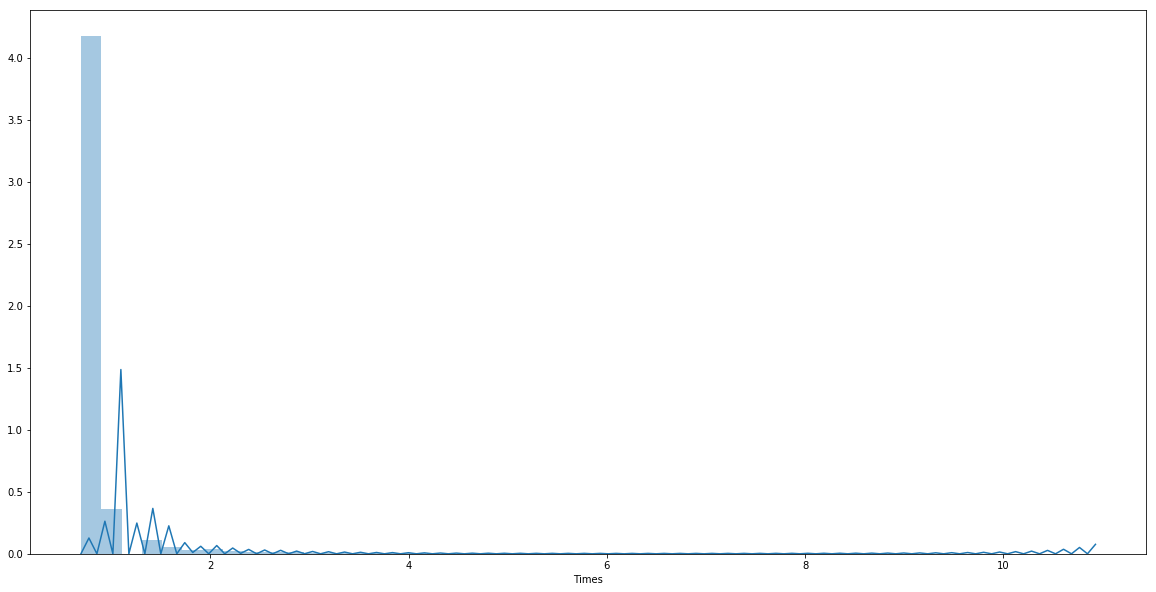

In [30]:
plt.figure(figsize=(20,10))
sns.distplot(X['Times'])

In [31]:
X.columns

Index(['Id', 'Password', 'Times', 'length', 'num_digit', 'num_alpha',
       'num_other', 'english_word', '123_in', 'qwer_in', 'female_name',
       'male_name', 'most10k', 'top100', 'top500', 'top1000', 'top10000',
       'top100000', 'top1000000', 'worst500', 'common_pass_win', 'num_upper',
       'num_lower', 'doubles', 'max_repeats', 'key_distance', 'nltk_tags',
       'pymorphy_morphs', 'Start_0_ngrams_1', 'Start_0_ngrams_2',
       'Start_0_ngrams_3', 'Start_0_ngrams_4', 'Start_1_ngrams_1',
       'Start_1_ngrams_2', 'Start_1_ngrams_3', 'Start_1_ngrams_4',
       'Start_2_ngrams_1', 'Start_2_ngrams_2', 'Start_2_ngrams_3',
       'Start_2_ngrams_4', 'Finish_0_ngrams_1', 'Finish_0_ngrams_2',
       'Finish_0_ngrams_3', 'Finish_0_ngrams_4', 'Finish_1_ngrams_1',
       'Finish_1_ngrams_2', 'Finish_1_ngrams_3', 'Finish_1_ngrams_4',
       'Finish_2_ngrams_1', 'Finish_2_ngrams_2', 'Finish_2_ngrams_3',
       'Finish_2_ngrams_4'],
      dtype='object')

In [32]:
corr = X.corr()

In [33]:
corr

,Id,Times,length,num_digit,num_alpha,num_other,english_word,123_in,qwer_in,female_name,...,Finish_0_ngrams_3,Finish_0_ngrams_4,Finish_1_ngrams_1,Finish_1_ngrams_2,Finish_1_ngrams_3,Finish_1_ngrams_4,Finish_2_ngrams_1,Finish_2_ngrams_2,Finish_2_ngrams_3,Finish_2_ngrams_4
Id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Times,NaN,1.000000,-0.158143,0.021493,-0.019751,-0.029113,0.045592,0.011561,0.006478,0.049251,...,0.010969,0.010397,0.028703,0.028752,0.028946,0.030125,0.021613,0.021013,0.021290,0.021445
length,NaN,-0.158143,1.000000,-0.071167,0.065978,0.086695,-0.069865,0.071593,0.030536,-0.009253,...,0.006807,0.005610,-0.009593,-0.009254,-0.008790,-0.007394,-0.012805,-0.012502,-0.012133,-0.011253
num_digit,NaN,0.021493,-0.071167,1.000000,-0.998173,-0.041670,0.170771,0.077901,-0.000821,-0.010194,...,-0.517734,-0.496074,-0.653802,-0.651921,-0.647483,-0.618866,-0.719031,-0.715847,-0.711022,-0.674147
num_alpha,NaN,-0.019751,0.065978,-0.998173,1.000000,-0.018748,-0.170403,-0.078163,0.000831,0.010276,...,0.519472,0.497970,0.655095,0.653198,0.648695,0.620213,0.720484,0.717297,0.712433,0.675740
num_other,NaN,-0.029113,0.086695,-0.041670,-0.018748,1.000000,-0.008077,0.003457,-0.000151,-0.001230,...,-0.022735,-0.025622,-0.013801,-0.013578,-0.012541,-0.015119,-0.015784,-0.015775,-0.015172,-0.018615
english_word,NaN,0.045592,-0.069865,0.170771,-0.170403,-0.008077,1.000000,0.026047,-0.011073,0.004138,...,-0.091443,-0.089154,-0.185022,-0.184256,-0.183316,-0.176960,-0.139163,-0.138305,-0.136999,-0.128459
123_in,NaN,0.011561,0.071593,0.077901,-0.078163,0.003457,0.026047,1.000000,0.018579,-0.001447,...,-0.080574,-0.079719,-0.099984,-0.101087,-0.101949,-0.104111,-0.134838,-0.135016,-0.135943,-0.138706
qwer_in,NaN,0.006478,0.030536,-0.000821,0.000831,-0.000151,-0.011073,0.018579,1.000000,-0.000298,...,0.005729,0.007240,0.003460,0.003753,0.003952,0.004833,0.006117,0.006695,0.006993,0.008736
female_name,NaN,0.049251,-0.009253,-0.010194,0.010276,-0.001230,0.004138,-0.001447,-0.000298,1.000000,...,0.005711,0.005180,0.006258,0.006178,0.006087,0.005859,0.004963,0.004984,0.004904,0.004629


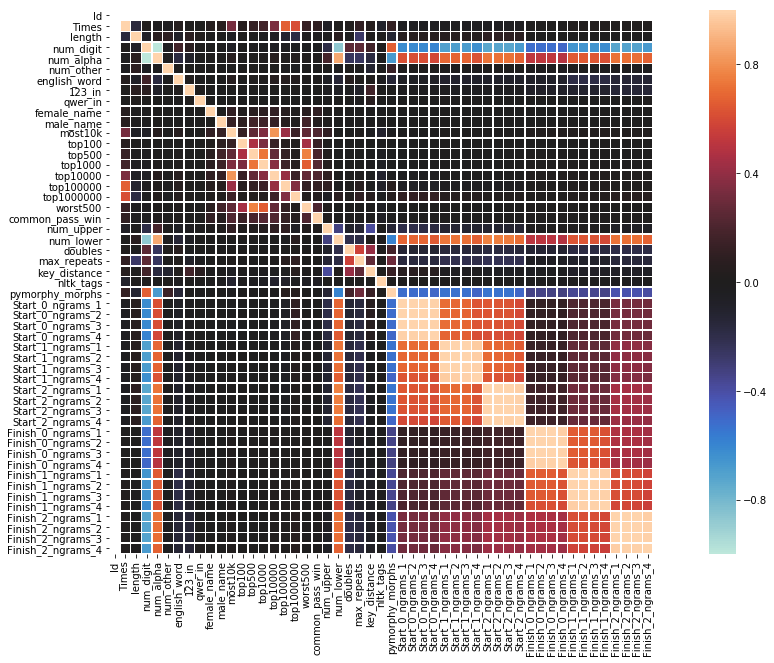

In [34]:
plt.figure(figsize=(20,10))
sns.heatmap(corr, center=0, square=True, linewidths=.5)

### Переходим к обучению

In [35]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.5f} (std: {1:.5f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [36]:
y = X['Times']
X = X.drop(axis=1, columns=['Times'], inplace=False)
X = X.drop(axis=1, columns=['Id'], inplace=False)
X = X.drop(axis=1, columns=['Password'], inplace=False)

In [37]:
X_test = dffeat[train_count:]
X_test = X_test.drop(axis=1, columns=['Times'], inplace=False)
X_test = X_test.drop(axis=1, columns=['Id'], inplace=False)
X_test = X_test.drop(axis=1, columns=['Password'], inplace=False)

In [38]:
y.shape

(4151496,)

### Строим простую модель, подбираем гиперпараметры

In [39]:
X.columns

Index(['length', 'num_digit', 'num_alpha', 'num_other', 'english_word',
       '123_in', 'qwer_in', 'female_name', 'male_name', 'most10k', 'top100',
       'top500', 'top1000', 'top10000', 'top100000', 'top1000000', 'worst500',
       'common_pass_win', 'num_upper', 'num_lower', 'doubles', 'max_repeats',
       'key_distance', 'nltk_tags', 'pymorphy_morphs', 'Start_0_ngrams_1',
       'Start_0_ngrams_2', 'Start_0_ngrams_3', 'Start_0_ngrams_4',
       'Start_1_ngrams_1', 'Start_1_ngrams_2', 'Start_1_ngrams_3',
       'Start_1_ngrams_4', 'Start_2_ngrams_1', 'Start_2_ngrams_2',
       'Start_2_ngrams_3', 'Start_2_ngrams_4', 'Finish_0_ngrams_1',
       'Finish_0_ngrams_2', 'Finish_0_ngrams_3', 'Finish_0_ngrams_4',
       'Finish_1_ngrams_1', 'Finish_1_ngrams_2', 'Finish_1_ngrams_3',
       'Finish_1_ngrams_4', 'Finish_2_ngrams_1', 'Finish_2_ngrams_2',
       'Finish_2_ngrams_3', 'Finish_2_ngrams_4'],
      dtype='object')

In [40]:
xgb_params = {
    'gamma': 0.8,
    'n_estimators': 4000,
    'learning_rate': 0.01,
    'n_jobs': -1,
    'max_depth': 8,
    'colsample_bytree': 0.6,
    'subsample': 0.8,
    'min_child_weight': 4,
    'eval_metric': 'rmse',
    'tree_method':'gpu_hist',
    'silent': False
}

In [41]:
xgb_model = xgb.XGBRegressor(**xgb_params)

In [42]:
X.shape

(4151496, 49)

In [43]:
y.shape

(4151496,)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [ ]:
xgb_model.fit(X, y)

In [ ]:
#xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='rmse', 
#              early_stopping_rounds=20, verbose=True)

In [ ]:
with open('xgbmodel-24-02-final.pickle', 'wb') as f:
    pickle.dump(xgb_model, f)

In [ ]:
with open('xgbmodel.pickle', 'rb') as f:
    xgb_model = pickle.load(f)

In [ ]:
X_test.head()

In [89]:
y_pred = xgb_model.predict(X_test)

In [ ]:
fe = pd.DataFrame(xgb_model.feature_importances_.reshape(1, -1), columns=X_test.columns)
fe.iloc[0].sort_values(ascending=False).plot.bar(figsize=(20,10))

In [ ]:
fit_params = {
    "early_stopping_rounds":10, 
    "eval_metric" : 'rmse', 
    "eval_set" : [[X_val, y_val]]
}

In [ ]:
params = {
    'min_child_weight':[3, 4, 5], 
    'gamma':[0.5, 0.8, 1],  
    'subsample':[0.5, 0.6, 0.8],
    'colsample_bytree':[0.5, 0.6, 0.8], 
    'max_depth': [3, 5, 8]
}

In [ ]:
xgb_params = {
    'n_estimators': 1000,
    'learning_rate': 0.01,
    'n_jobs': -1,
    'eval_metric': 'rmse',
    'tree_method':'gpu_hist',
}

In [ ]:
xgb_model = xgb.XGBRegressor(**xgb_params)

In [ ]:
grid = RandomizedSearchCV(xgb_model, scoring='neg_mean_squared_error', param_distributions=params,
                                   n_iter=10, cv=3, n_jobs=1, verbose=1, fit_params=fit_params)
grid.fit(X, y)

In [ ]:
report(grid.cv_results_)

In [ ]:
fe = pd.DataFrame(grid.best_estimator_.feature_importances_.reshape(1, -1), columns=X_test.columns)
fe.iloc[0].sort_values(ascending=False).plot.bar(figsize=(20,10))

In [ ]:
y_pred = grid.best_estimator_.predict(X_test)

In [ ]:
with open('xgbmodel-24-02-final.pickle', 'wb') as f:
    pickle.dump(grid.best_estimator_, f)

In [50]:
with open('xgbmodel-24-02-final.pickle', 'rb') as f:
    xgb_model = pickle.load(f)

[23:05:28] C:\Users\Administrator\Desktop\xgboost\src\learner.cc:362: Parameter 'predictor' has been recovered from the saved model. It will be set to 'gpu_predictor' for prediction. To override the predictor behavior, explicitly set 'predictor' parameter as follows:
  * Python package: bst.set_param('predictor', [new value])
  * R package:      xgb.parameters(bst) <- list(predictor = [new value])
  * JVM packages:   bst.setParam("predictor", [new value])


### Формируем сабмит

In [52]:
result = pd.DataFrame(columns=['Id', 'Times'])
result['Id'] = dftest['Id']

In [90]:
y_pred

array([0.71277624, 0.68955016, 0.69415957, ..., 0.69442147, 0.7016204 ,
       1.2395222 ], dtype=float32)

In [91]:
y_pred = np.expm1(y_pred)

In [92]:
y_pred.mean()

1.8508159

In [93]:
y_pred

array([1.0396459 , 0.99281883, 1.0020258 , ..., 1.0025501 , 1.0170186 ,
       2.4539628 ], dtype=float32)

In [94]:
for i, elem in enumerate(y_pred):
    if elem < 1.0:
        y_pred[i] = 1.0

In [96]:
result['Times'] = y_pred

In [97]:
result.to_csv('./data/submits/xgb_with_all_features_expm1_full_data_final.csv', index=False)